In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

%matplotlib inline

In [4]:
train = pd.read_csv('./data/train.csv',index_col='index')
train.head()

/home/frodos/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,event_id,X,Y,Z,TX,TY,chi2,signal,brick_number
index,,,,,,,,,
0,-999,66162.843750,65620.031250,0.0,0.166890,0.276674,2.988714,0.0,44
1,-999,43900.445312,67091.671875,0.0,-0.179967,-0.478795,1.901420,0.0,98
2,-999,37564.019531,26618.890625,55599.0,-0.267820,-0.282087,2.510245,0.0,64
3,-999,39380.027344,48135.425781,19395.0,0.265197,-0.577493,1.215219,0.0,63
4,-999,65040.781250,44018.468750,12930.0,-0.711161,-0.245592,2.973661,0.0,2


In [5]:
%%time
def getTracks(layer0,layer1,dtxy,dz):
    '''
    layer0, layer1 - Pandas dataframe with track parameters
    dx, dy, dtx, dty - errors of parameters
    dz - distance between layer1 and layer0
    '''

    layer0Arr = layer0.reset_index().as_matrix(columns = ['index', 'X', 'Y', 'TX', 'TY', 'signal'])
    layer1Arr = layer1.sort_values(by='X',ascending=True).reset_index().as_matrix(columns = ['index', 'X', 'Y', 'TX', 'TY', 'signal'])

    res = np.empty([0,10])
    for track in layer0Arr:
        #calculate new pos
        newTX = track[3]
        newTY = track[4]

        #print 
        x0 = track[1]+dz*np.tan(track[3])
        x1 = x0 + dz*np.tan(track[3]-dtxy) # estimate possible region of scattering
        lEdge = np.searchsorted(layer1Arr[:,1],x1,side='left')

        x2 = x0 + dz*np.tan(track[3]+dtxy)        
        rEdge = np.searchsorted(layer1Arr[:,1],x2,side='right')
        
        subSet = layer1Arr[lEdge:rEdge,:]        
        y0 = track[2]+dz*np.tan(track[4])
        y1 = y0 + dz*np.tan(track[4]-dtxy)
        y2 = y0 + dz*np.tan(track[4]+dtxy)
               
        subSet = subSet[np.where((subSet[:,2]>y1) &  (subSet[:,2]<y2) & (subSet[:,3]>newTX-dtxy) & (subSet[:,3]<newTX+dtxy) & (subSet[:,4]>newTY-dtxy) & (subSet[:,4]<newTY+dtxy)),:][0]
        
        if subSet.shape[0] > 0:
            #print subSet
            r = np.power(subSet[:,1]-x0,2)+np.power(subSet[:,2]-y0,2)
            da = subSet[:,3]-newTX
            db = subSet[:,4]-newTY
            subSet = np.hstack((subSet,np.expand_dims(r,1),np.expand_dims(da,1),np.expand_dims(db,1),track[0]*np.ones([db.shape[0],1])))
            res = np.vstack((res,subSet))

    return res        

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


In [6]:
def getSet(df,dtxy = 0.2):
    finalArr = np.ones([0,10])
    for brickId, brick in df.groupby('brick_number'):
        # create dictionaries
        zPos = np.sort(brick.Z.unique())
        zPosDict = dict(enumerate(zPos)) # dictionary of positions (layerNumber => position)
        zDiffDict = dict(enumerate(np.diff(zPos))) # dictionaru of distances (layerNumber => distance to the next layer)
        layerDict = {v: k for k, v in zPosDict.iteritems() } # dictionary of layer number (position => layerNumber)

        # add extra feature - layer number
        brick = brick.assign(layerId = brick.Z.map(layerDict))
        
        for layerId in np.sort(brick.layerId.unique())[0:-1]:
            dz = zDiffDict.get(layerId)

            layer0 = brick.query('layerId == @layerId')
            layer1 = brick.query('layerId == @layerId+1')
            arr = getTracks(layer0,layer1,dtxy,dz)
            finalArr = np.vstack([finalArr,arr])
            
    ## name of colums
    cols = ['index', 'X', 'Y', 'TX', 'TY', 'signal', 'r', 'da', 'db', 'parent']
    fdf = pd.DataFrame(finalArr,columns=cols)
    fdf.set_index('index',inplace=True)

    print 'Done'
    return fdf

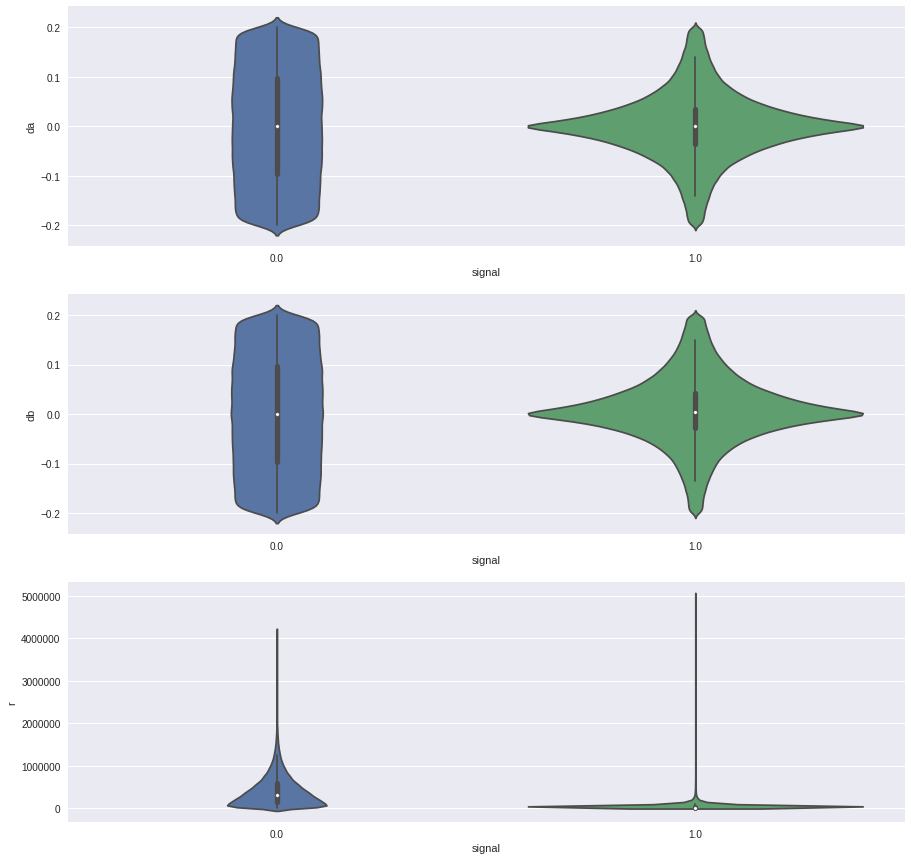

In [8]:
plt.figure(figsize=[15,15])
plt.subplot(311)
sns.violinplot(y="da", x = "signal", data=fdf, split=True);

plt.subplot(312)
sns.violinplot(y="db", x = "signal", data=fdf, split=True);

plt.subplot(313)
sns.violinplot(y="r", x = "signal", data=fdf, split=True);

Done


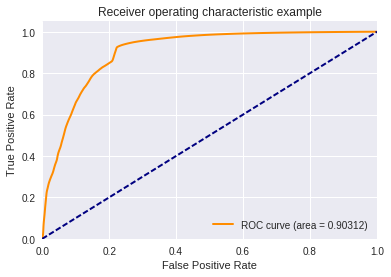

In [9]:
fdf = getSet(train,0.3)

clf = GaussianNB()

X = fdf.loc[:,['X','Y','TX','TY','r','da','db']]
Y = fdf.signal
clf.fit(X,Y)
pred = clf.predict_proba(X)
fpr, tpr, thresholds = metrics.roc_curve(Y, pred[:,1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#predDf = pd.DataFrame(pred[:,1],columns=['prob'],index=fdf.index)
#
#train2 = train.merge(predDf,left_index=True,right_index=True,how='left')
#train2.prob.fillna(0.0,inplace=True)
#
#fpr, tpr, thresholds = metrics.roc_curve(train2.signal, train2.prob, pos_label=1)
#roc_auc = metrics.auc(fpr, tpr)

#plt.figure()
#lw = 2
#plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic example')
#plt.legend(loc="lower right")
#plt.show()

In [10]:
test = pd.read_csv('./data/test.csv',index_col='index')
test = test.assign(signal = 0.0)
test.head()

,X,Y,Z,TX,TY,chi2,brick_number,signal
index,,,,,,,,
0,56472.238281,54979.070312,19395.0,-0.161979,-0.471001,2.681201,68,0.0
1,70306.289062,42301.472656,37497.0,-0.205394,-0.042299,1.413991,28,0.0
2,30427.056641,30543.578125,42669.0,0.234635,0.114081,2.702541,34,0.0
3,45467.257812,27151.515625,71115.0,-0.319327,0.561254,0.593076,28,0.0
4,59172.652344,33032.457031,41376.0,0.467150,-0.332887,2.236792,44,0.0


In [12]:
#fdf2 = getSet(test,0.3)

#X = fdf2.loc[:,['X','Y','TX','TY','r','da','db']]
#pred = clf.predict_proba(X)
predDf = pd.DataFrame(pred[:,1],columns=['prob'],index=fdf2.index)

train2 = train.merge(predDf,left_index=True,right_index=True,how='left')
train2.prob.fillna(0.0,inplace=True)

In [ ]:
train2.to_csv(columns=['prob'])